# Exploring similarity in molecules

In this notebook we will use the [RDKit library](https://www.rdkit.org) (accessible as a Python module) to investigate the properties of a series of molecules. In particular, we will look at ways to determine _similarity_ between molecules, a concept which is very intuitive for human chemists, but not very easy to define formally for a computer.

In [1]:
import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import rdFMCS, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Cluster import Butina
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

import networkx as nx
import seaborn as sns

## Exploring the molecular graph: identifying chemical groups

We start by loading a small dataset of molecules, which are stored in the [SDF format](https://en.wikipedia.org/wiki/Chemical_table_file#SDF). This files comes from the examples of RDKit, and contains several small molecules that are biologically active on the 5-HT3 receptor.

In [2]:
molecules = list(Chem.SDMolSupplier('actives_5ht3.sdf'))
print('Number of molecules loaded:', len(molecules))

Number of molecules loaded: 180


We can look at some of the molecules:

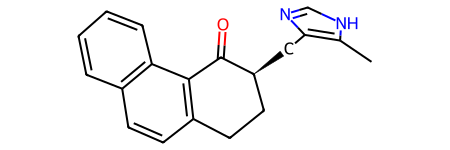

In [3]:
molecules[27]

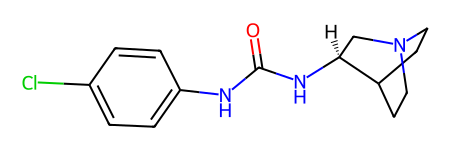

In [4]:
molecules[19]

How do we identify specific chemical features in molecules? We will use a function that searches a molecular graph for a substructure, or “pattern”. For example, how many molecules contain a —NH—CO–NH– group? They are called [_ureas_](https://en.wikipedia.org/wiki/Ureas)

In order to solve this question, we start by creating the “pattern” for which we want to search. We do this by specifying the series of atoms, in the [SMARTS](https://en.wikipedia.org/wiki/SMILES_arbitrary_target_specification) description:

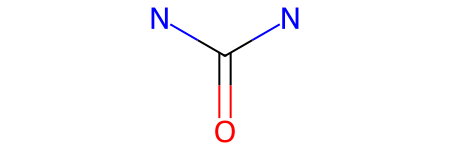

In [5]:
patt = Chem.MolFromSmarts('[NH]-C(=O)-[NH]')
patt

Then we can use the `HasSubstructMatch()` function to identify if a given molecule features this substructure. We call the function on all molecules, selecting the ones that match:

In [6]:
matches = [mol for mol in molecules if mol.HasSubstructMatch(patt)]
print('Number of matches found:', len(matches))

Number of matches found: 7


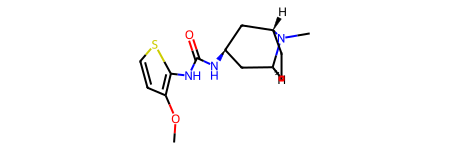

In [7]:
matches[0]

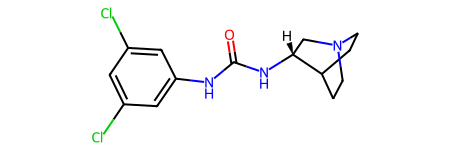

In [8]:
matches[1]

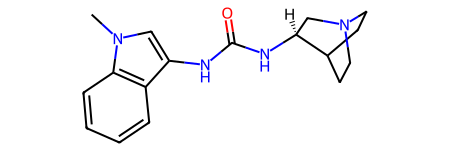

In [9]:
matches[5]

We can already see that some of those molecules look similar. We will get back to this later.

Let’s try with another type of feature: how many molecules in that data set have a sulfur atom inside an aromatic ring? The SMARTS string for “aromatic sulfur” is `s` (lowercase), so that is easy:

In [10]:
patt = Chem.MolFromSmarts('s')
matches = [x for x in molecules if x.HasSubstructMatch(patt)]
print('Number of matches found:', len(matches))

Number of matches found: 12


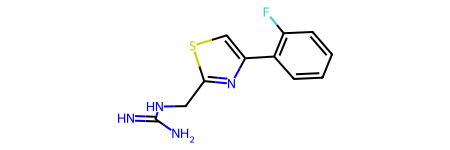

In [11]:
matches[10]

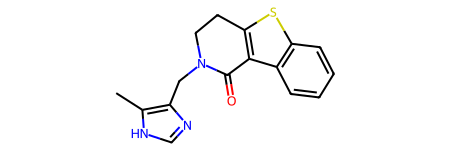

In [12]:
matches[4]

## Matrix and graph representation of molecules

If we want to explore the molecular graph further, we have several options. We can for example get the complete list of atoms and bonds in a given molecule:

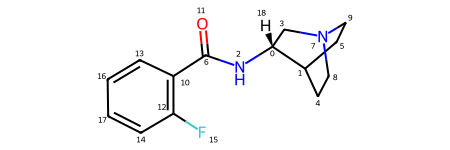

In [13]:
IPythonConsole.drawOptions.addAtomIndices = True

mol = molecules[11]
mol

In [14]:
# Loop over all atoms
for at in mol.GetAtoms():
    print(at.GetSymbol(), end=' ')
print()

# Loop over all bonds
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())

C C N C C C C N C C C O C C C F C C 
0 1 SINGLE
0 2 SINGLE
0 3 SINGLE
1 4 SINGLE
1 5 SINGLE
2 6 SINGLE
3 7 SINGLE
4 8 SINGLE
5 9 SINGLE
6 10 SINGLE
6 11 DOUBLE
10 12 AROMATIC
10 13 AROMATIC
12 14 AROMATIC
12 15 SINGLE
13 16 AROMATIC
14 17 AROMATIC
7 8 SINGLE
7 9 SINGLE
16 17 AROMATIC


Another interesting object, when we want to algorithmically study molecular structures, is the [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). It is a square, symmetric matrix where each entry $A_{ij}$ tells you if atoms $i$ and $j$ are bonded ($A_{ij} = 1$) or not ($A_{ij} = 0$).

In [15]:
Chem.GetAdjacencyMatrix(mol)

array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

The adjacency matrix (along with the list of types of each atom) is a representation of the molecular structure. It is not very compact representation, having a lot of zeros. Hence, it is rarely used directly as descriptor of a molecule.

Note that it is also possible to calculate a version where bond orders are represented (instead of simply 1 or 0, for “connected” or “unconnected”). Can you spot the molecule’s double bond? Notice also how aromatic bonds have a bond order of 1.5:

In [16]:
Chem.GetAdjacencyMatrix(mol, useBO=True)

array([[0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 2. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ,

We can use other representations to encode the molecular structure. One is the “molecular graph” — where the work “graph” is meant in the [mathematical meaning](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) of graph theory. We manipulate these graphs easily with the [NetworkX](https://networkx.org) library. They can be created directly form the adjacency matrix:

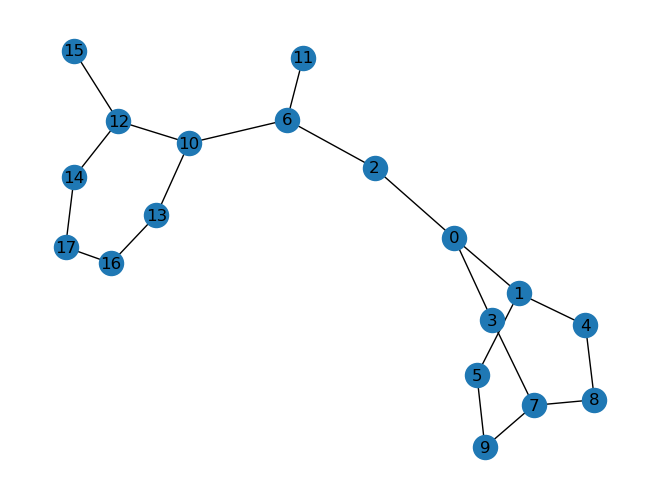

In [17]:
atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
am = Chem.GetAdjacencyMatrix(mol, useBO=True)
graph = nx.from_numpy_array(am)

nx.draw(graph, with_labels = True)

Of course, visually it is not as “physical” or easy to visualize as our usual chemical representation. But the mathematical theory of graphs is a very-well known topic, and there are lots of studies (and software implementations) on how to represent such graphs.

We can figure out what the _diameter_ of the graph is (can you guess what it is?):

In [18]:
nx.algorithms.distance_measures.diameter(graph)

9

Or determine what atoms correspond to the _center_ of the graph:

In [19]:
nx.algorithms.distance_measures.center(graph)

[2, 6]

If we draw the molecular structure and label the atoms by their indices, does it make sense? Can you see that path that corresponds to the diameter?

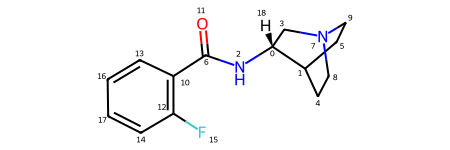

In [20]:
IPythonConsole.drawOptions.addAtomIndices = True
mol

In that way, we can now use established algorithms, designed and optimized for the representation of graphs for machine learning, in order to encode molecular structures. If you are interested in how this is done, you can have look at packages like [Karate Club](https://karateclub.readthedocs.io/en/latest/) and [graph2vec](https://github.com/benedekrozemberczki/graph2vec).

## Identifying common substructures

We can also use functions to search for (and identify) the common substructures of a set of molecules. Let’s pick three different molecules:

In [21]:
mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")

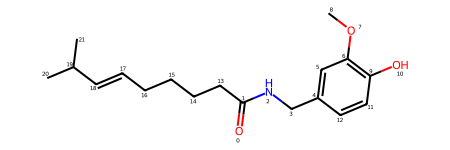

In [22]:
mol1

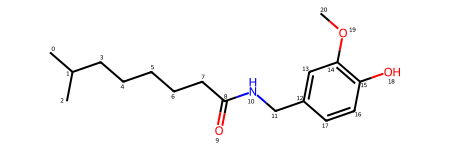

In [23]:
mol2

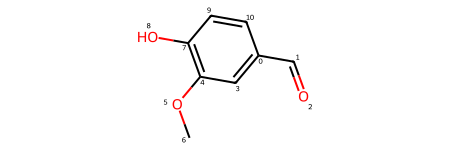

In [24]:
mol3

What does these three molecules have in common? We will be searching for their **maximum common structure**, or MCS. It will be, intuitively, the largest “part” common to all molecules in the set:

In [25]:
res = rdFMCS.FindMCS([mol1, mol2, mol3])
res

We can visualize this common substructure by asking for its SMARTS representation, then drawing it:

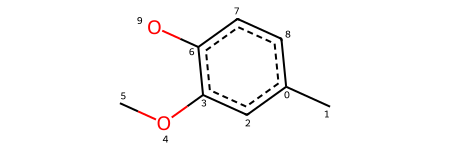

In [26]:
Chem.MolFromSmarts(res.smartsString)

This can provide for a definition of “similarity” between molecules: we can say that molecules are similar if they share a large substructure. For example, which are the closest of the three molecules we have chosen?

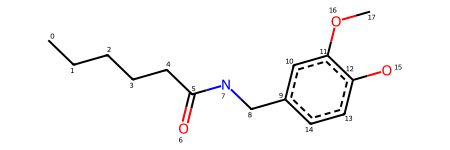

In [27]:
Chem.MolFromSmarts(rdFMCS.FindMCS([mol1, mol2]).smartsString)

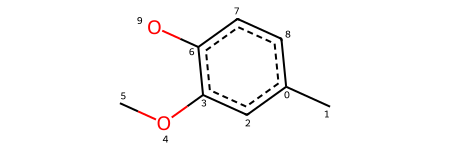

In [28]:
Chem.MolFromSmarts(rdFMCS.FindMCS([mol1, mol3]).smartsString)

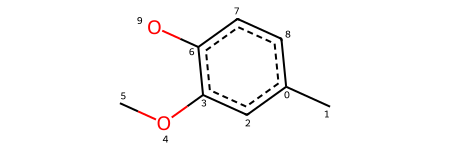

In [29]:
Chem.MolFromSmarts(rdFMCS.FindMCS([mol2, mol3]).smartsString)

Molecules 1 and 2 have a larger common substructure, and probably most chemists would say that they are quite similar.

## Graph-based similarity measures

But other measures of similarity are also possible. For example, compare these two molecules:

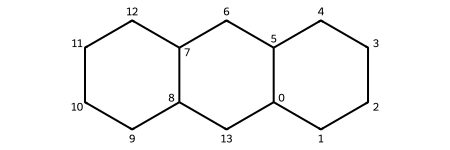

In [30]:
mol4 = Chem.MolFromSmiles("C12CCCCC1CC3C(CCCC3)C2")
mol4

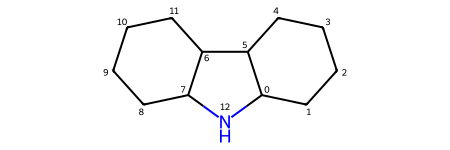

In [31]:
mol5 = Chem.MolFromSmiles("C12CCCCC1C3C(CCCC3)N2")
mol5

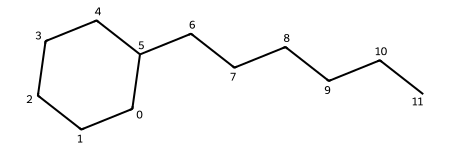

In [32]:
Chem.MolFromSmarts(rdFMCS.FindMCS([mol4, mol5]).smartsString)

Their common substructure is basically restricted to one ring and a long chain, but it seems to us they have more in common than that. After all, they differ by a bond and one atom! Their graphs must be very close.

We can actually use another metric of similarity, called the [**graph edit distance**](https://en.wikipedia.org/wiki/Graph_edit_distance), which is the number of changes you have to make to the molecular graph to get from one molecular to another. It can be [calculated by `networkx`](http://proteinsandwavefunctions.blogspot.com/2020/01/computing-graph-edit-distance-between.html):

In [33]:
def mol2graph(mol):
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    am = Chem.GetAdjacencyMatrix(mol, useBO=True)
    return nx.from_numpy_array(am)

nx.graph_edit_distance(mol2graph(mol4), mol2graph(mol5), edge_match=lambda a,b: a['weight'] == b['weight'])

4.0

Can you see what are the 4 changes you have to make to the molecular graph to get from one molecular to the other?

## Fingerprints and similarity

The examples above are pretty “low-level” (or simple) definitions of molecular similarity. But we do not have to reinvent the wheel! Researchers have been working hard to define efficient measures of similarity between molecules, and the most common algorithms are already implemented in [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity).

Molecular fingerprints are a way of encoding the structure of a molecule. The most common type of fingerprint is a series of binary digits (bits), that are not directly interepretable.

In [34]:
Chem.RDKFingerprint(mol1)

We can, however, compare these fingerprints to calculate a measure of similarity between different molecules:

0.9017632241813602
0.4268867924528302
0.4368932038834951


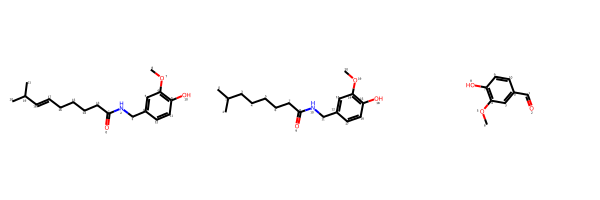

In [35]:
def similarity(a, b):
    return DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(a), Chem.RDKFingerprint(b))

print(similarity(mol1, mol2))
print(similarity(mol1, mol3))
print(similarity(mol2, mol3))

Draw.MolsToGridImage([mol1, mol2, mol3])

The numbers for similarity appear to agree with our intuition. We can extend them, and calculate a matrix of similarity between all possible pairs of molecules. We'll first calculate all the $n$ fingerprints, then all the similarities in an $n \times n$ array.

In [36]:
fps = [Chem.RDKFingerprint(mol) for mol in molecules]

n = len(molecules)
simil = np.ndarray((n, n))
for i in range(n):
    for j in range(i+1):
        simil[i,j] = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        simil[j,i] = simil[i,j]

We can plot it, every point on this graph is a value of similarity between two molecules (given on X and Y axes):

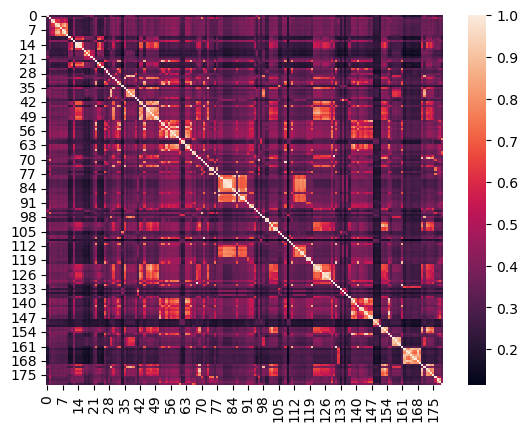

In [37]:
_ = sns.heatmap(simil)

We can clearly see that some molecules appear “grouped” together in the list (see the molecules around number 84). Some molecules look like they have very little in common with all others (around 148). Let look at molecules similar to number 82.

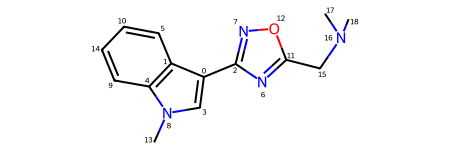

In [38]:
molecules[82]

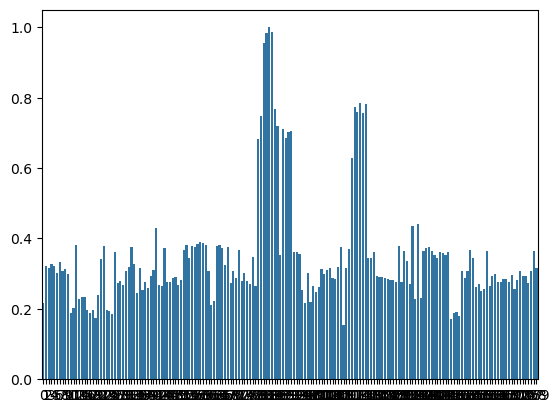

In [39]:
_ = sns.barplot(x=np.arange(n), y=simil[82])

We now select all molecules than have more than 0.7 similarity, and show them.

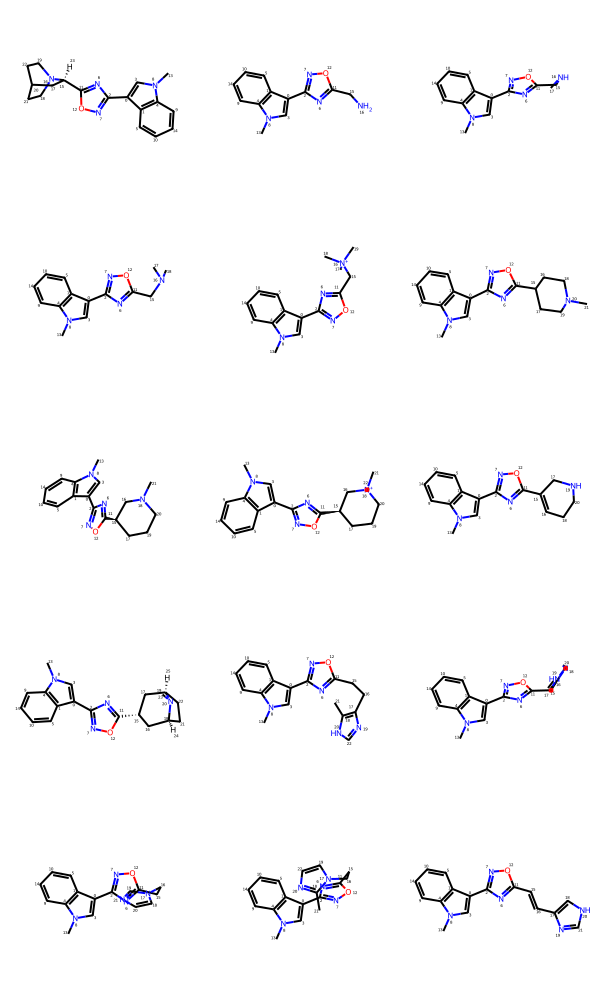

In [40]:
l = [i for i in range(n) if simil[82,i] > 0.7]
Draw.MolsToGridImage([molecules[i] for i in l])

OK, it seems pretty clear what that they all share the same basic structure.

We can then use that information about similarity to perform additional tasks. For example, we can try to select a small number of molecules that are chemically diverse from the set.

In [41]:
# We need to provide a distance function. Choose dist = 1 - similarity
def dist(i, j):
    return 1 - simil[i,j]

picker = MaxMinPicker()
pickIndices = picker.LazyPick(dist, n, 10, seed=42)
print(list(pickIndices))

[67, 109, 10, 135, 99, 162, 151, 0, 106, 137]


Let's have a look at the molecules that were picked:

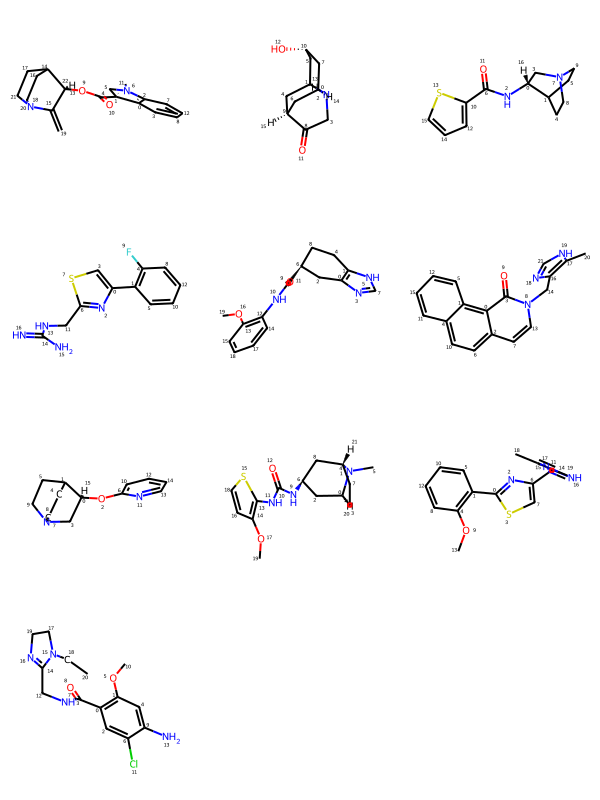

In [42]:
Draw.MolsToGridImage([molecules[i] for i in pickIndices])

We can display their similarity matrix, and see that it is low in all cases:

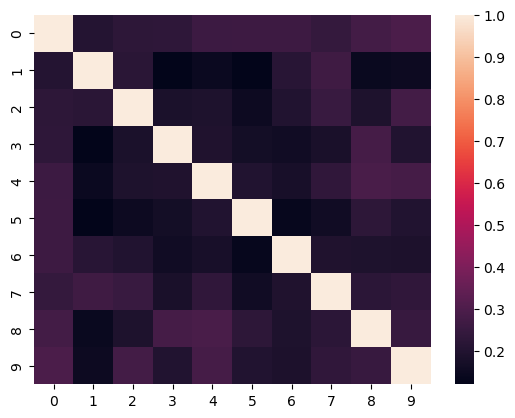

In [43]:
m = np.array([[simil[i,j] for j in pickIndices] for i in pickIndices])
_ = sns.heatmap(m)

If we exclude the diagonal (similarity of each molecule with itself is always equal to 1), the maximum value of similarity between two molecules in the set of 10 that was picked is:

In [44]:
np.max(np.abs(m - np.eye(10)))

0.2952167414050822

So they are indeed quite different (for the given measure of similarity that we have chosen).

## Going further

In this notebook, we have seen the basics of the exploration of chemical structures, the identification of chemical groups and the characterization of molecular similarity. There are several ways we could take this study further. One of the ideas would be to expand the notebook to load a larger list of molecules. The file `ApprovedDrugsLibrary.sdf` contains a list of all drugs approved by the FDA (US Food and Drug Administration), as of 2017. It contains 1800 molecules.

Here are some ideas for you to continue this project:

1. From the FDA approved drugs list, can you load the molecules, **explore their structures and properties**. What are the common chemical groups? How frequent is each functional group? What are the most common cycles and heterocycles?
2. Using the FDA list, you can use unsupervised learning, and more specifically **clustering methods** (based on molecular fingerprints), to identify the different groups of similar molecules. What categories emerge? Can you classify the different drugs in this way?
3. The list of molecules contains some information about their therapeutic use. Can you extract it, and compare the characteristics of different types of drugs?